<a href="https://colab.research.google.com/github/serdarbozoglan/My_NLP/blob/master/Intent_Recognition_with_BERT_and_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Before Starting Slect GPU from the RunTime

In [0]:
# This shows our gpu spesifications
!nvidia-smi

In [0]:
!pip install tensorflow-gpu >> /dev/null

In [0]:
!pip install --upgrade grpcio

In [0]:
!pip install tqdm 

In [0]:
!pip install bert-for_tf2

In [0]:
!pip install sentencepiece

In [0]:
import os
import math
import datetime

from tqdm import tqdm
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras

import bert
from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from sklearn.metrics import confusion_matrix, classification_report

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLOR_PALLETE = ["#01BEFE", '#FFDD00', '#FF7D00', '#FF006D', '#ADFF02', '#8F00FF']

sns.set_palette(sns.color_palette(HAPPY_COLOR_PALLETE))
rcParams['figure.figsize'] = 12,8

RANDOM_SEED =4299
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**DATA: **

https://www.curiousily.com/posts/intent-recognition-with-bert-using-keras-and-tensorflow-2/

https://www.youtube.com/watch?v=gE-95nFF4Cc

In [0]:
!gdown --id 1OlcvGWReJMuyYQuOZm149vHWwPtlboR6 --output train.csv
!gdown --id 1Oi5cRlTybuIF2Fl5Bfsr-KkqrXrdt77w --output valid.csv
!gdown --id 1ep9H6-HvhB4utJRLVcLzieWNUSG3P_uF --output test.csv

Downloading...
From: https://drive.google.com/uc?id=1OlcvGWReJMuyYQuOZm149vHWwPtlboR6
To: /content/train.csv
100% 799k/799k [00:00<00:00, 53.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Oi5cRlTybuIF2Fl5Bfsr-KkqrXrdt77w
To: /content/valid.csv
100% 43.3k/43.3k [00:00<00:00, 16.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ep9H6-HvhB4utJRLVcLzieWNUSG3P_uF
To: /content/test.csv
100% 43.1k/43.1k [00:00<00:00, 69.6MB/s]


Indirilen dosyalari Files/content icinde gorebilirisin

In [0]:
train = pd.read_csv("train.csv")
valid = pd.read_csv("valid.csv")
test = pd.read_csv("test.csv")

In [0]:
# We will merge train and validation and validation will be by splitting in Keras
train = train.append(valid).reset_index(drop=True)

In [0]:
train.shape

(13784, 2)

In [0]:
train.head()

,text,intent
0,listen to westbam alumb allergic on google music,PlayMusic
1,add step to me to the 50 clásicos playlist,AddToPlaylist
2,i give this current textbook a rating value of...,RateBook
3,play the song little robin redbreast,PlayMusic
4,please add iris dement to my playlist this is ...,AddToPlaylist


In [0]:
train['intent'].value_counts(normalize=True)

PlayMusic               0.146111
GetWeather              0.144806
BookRestaurant          0.143717
RateBook                0.143355
SearchScreeningEvent    0.141613
SearchCreativeWork      0.141251
AddToPlaylist           0.139147
Name: intent, dtype: float64

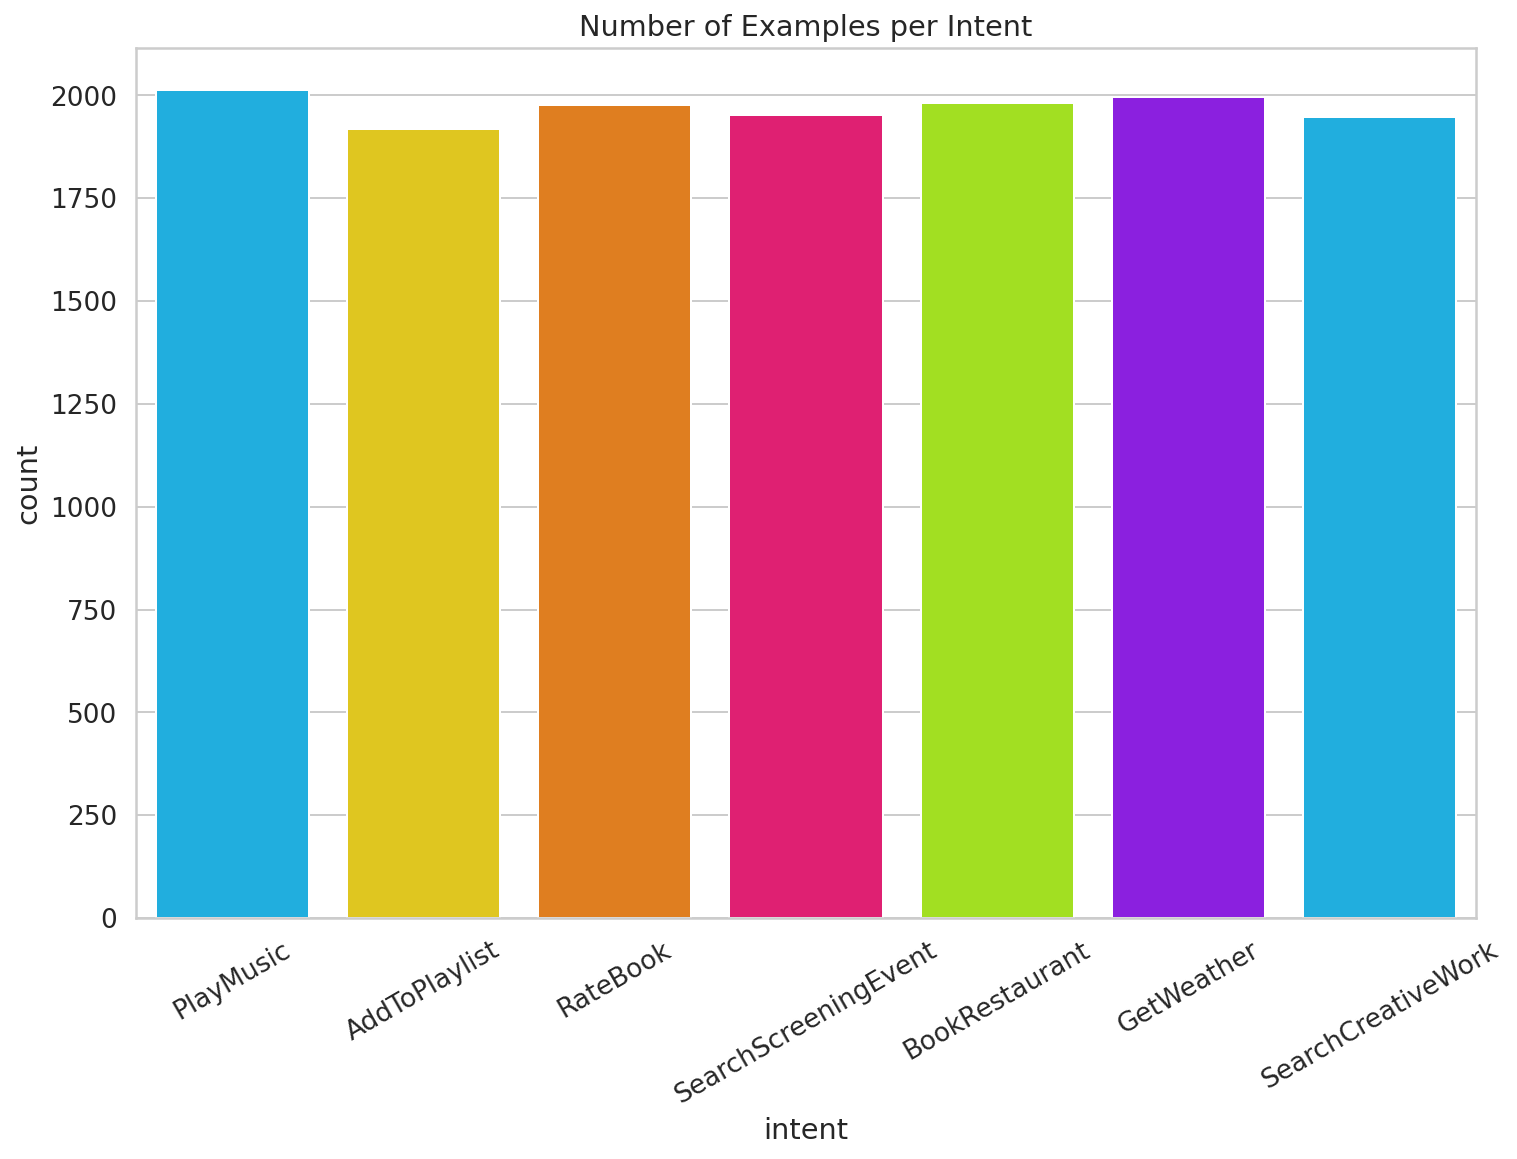

In [0]:
chart = sns.countplot(train['intent'], palette=HAPPY_COLOR_PALLETE)
plt.title('Number of Examples per Intent')
plt.xticks(rotation=30);

### Intent Recognition with BERT

In [0]:
!wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
!unzip uncased_L-12_H-768_A-12.zip

--2020-04-06 03:53:02--  https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.167.128, 2a00:1450:400c:c0a::80
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.167.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407727028 (389M) [application/zip]
Saving to: ‘uncased_L-12_H-768_A-12.zip’

uncased_L-12_H-768_ 100%[===================>] 388.84M  94.5MB/s    in 4.1s    

2020-04-06 03:53:06 (94.5 MB/s) - ‘uncased_L-12_H-768_A-12.zip’ saved [407727028/407727028]

Archive:  uncased_L-12_H-768_A-12.zip
   creating: uncased_L-12_H-768_A-12/
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.meta  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001  
  inflating: uncased_L-12_H-768_A-12/vocab.txt  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.index  
  inflating: uncased_L-12_H-768_A-12/bert_config.json  


In [0]:
os.makedirs('model', exist_ok=True)
# content icine model diye bir klasor olusturuyoruz ve unzip ettigimiz modeli oraya tasiyacagiz

In [0]:
!mv uncased_L-12_H-768_A-12/ model

In [0]:
bert_model_name = 'uncased_L-12_H-768_A-12'

#bert checkpoint direktoruyu tanimliyoruz
bert_ckpt_dir = os.path.join('model/', bert_model_name)

#bert model checkpoint
bert_ckpt_file = os.path.join(bert_ckpt_dir, 'bert_model.ckpt')

#bert config file
bert_config_file = os.path.join(bert_ckpt_dir, 'bert_config.json')

## Preprocessing

In [0]:
class IntentDetectionData:
  DATA_COLUMN = "text" # text column in dataframe
  LABEL_COLUMN = "intent"

  def __init__(
    self,
    train,
    test,
    tokenizer: FullTokenizer,
    classes,
    max_seq_len=192
  ):
    self.tokenizer = tokenizer
    self.max_seq_len = 0
    # classes are unique labels in the df
    self.classes = classes

    ((self.train_x, self.train_y), (self.test_x, self.test_y)) =\
     map(self._prepare, [train, test])

    # max_seq_len default olarak 192 olarak belirledik simdilik ama bu kadar uzuna ihtiyacimiz olmayabilir
    # prepare methodu bunu hesapladiktan sonra gercek degeri burada belirleyecegiz
    # eger belirlenden daha uzunsa burada kesecegiz eger daha kisaysa onu deger olarak alacagiz  
    print("max seq_len", self.max_seq_len)
    self.max_seq_len = min(self.max_seq_len, max_seq_len)

    # padding burada yapacagiz
    self.train_x, self.test_x = map(
      self._pad,
      [self.train_x, self.test_x]
    )

  def _prepare(self, df):
    x, y = [], []

    for _, row in tqdm(df.iterrows()):
      text, label =\
       row[IntentDetectionData.DATA_COLUMN], \
       row[IntentDetectionData.LABEL_COLUMN]
      # Tokenizing is done here
      tokens = self.tokenizer.tokenize(text)
      tokens = ["[CLS]"] + tokens + ["[SEP]"]

      token_ids = self.tokenizer.convert_tokens_to_ids(tokens)
      self.max_seq_len = max(self.max_seq_len, len(token_ids))
      x.append(token_ids)
      y.append(self.classes.index(label))

    return np.array(x), np.array(y)

  def _pad(self, ids):
    x = []
    for input_ids in ids:
      cut_point = min(len(input_ids), self.max_seq_len - 2)
      input_ids = input_ids[:cut_point] # we're substracting CLS and SEP tokens 
      # mesela max_seq_len 30 ve len(input_ids) 25 aradaki fark yani 5 kadar 0 ile pad ederiz
      input_ids = input_ids + [0] * (self.max_seq_len - len(input_ids)) # eksik kalan kismi 0 ile pad ederiz
      x.append(np.array(input_ids))
    return np.array(x)

In [0]:
tokenizer = FullTokenizer(vocab_file=os.path.join(bert_ckpt_dir, 'vocab.txt'))
#tokenizer = FullTokenizer(vocab_file=('model/uncased_L-12_H-768_A-12/vocab.txt'))

In [0]:
tokens = tokenizer.tokenize("I can't wait to visit Turkey")
token_id = tokenizer.convert_tokens_to_ids(tokens)
print(tokens)
print(token_id)

['i', 'can', "'", 't', 'wait', 'to', 'visit', 'turkey']
[1045, 2064, 1005, 1056, 3524, 2000, 3942, 4977]


**Fine Tuning**

Let’s make BERT usable for text classification! We’ll load the model and attach a couple of layers on it

In [0]:
def create_model(max_seq_len, bert_config_file, bert_ckpt_file):

    with tf.io.gfile.GFile(bert_config_file, 'r') as reader:
        # we're reading the bert config file here
        # bert config ==> bc  
        bc = StockBertConfig.from_json_string(reader.read())

        # geeting the parameters from config file
        bert_params = map_stock_config_to_params(bc)

        # adapter size is used in fine tuning to make it faster but we will not use here now
        bert_params.adapter_size = None

        bert = BertModelLayer.from_params(bert_params, name='bert')

    input_ids = keras.layers.Input(shape=(max_seq_len, ), dtype='int32', name='input_ids')
    bert_output = bert(input_ids)

    print('bert shape: ', bert_output.shape)
    cls_out = keras.layers.Lambda(lambda seq: seq[:, 0, :])(bert_output)
    drop1 = keras.layers.Dropout(0.5)(cls_out)
    dense1 = keras.layers.Dense(units=768, activation='tanh')(drop1)
    drop2 = keras.layers.Dropout(0.5)(dense1)
    output_layer = keras.layers.Dense(len(classes), activation='softmax')(drop2)

    model = keras.Model(inputs=input_ids, outputs=output_layer)
    model.build(input_shape=(None, max_seq_len)) # first parameter for batch size and SHOULD BE NONE, keras infers it

    load_stock_weights(bert, bert_ckpt_file)

    return model

In [0]:
classes = train['intent'].unique().tolist()
classes

['PlayMusic',
 'AddToPlaylist',
 'RateBook',
 'SearchScreeningEvent',
 'BookRestaurant',
 'GetWeather',
 'SearchCreativeWork']

In [0]:
data = IntentDetectionData(train, test, tokenizer, classes, max_seq_len=128)

13784it [00:05, 2676.21it/s]
700it [00:00, 2513.92it/s]


max seq_len 38


In [0]:
model = create_model(data.max_seq_len, bert_config_file, bert_ckpt_file)

bert shape:  (None, 38, 768)
Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7ff20a4e0278> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights


In [0]:
data.train_x.shape

(13784, 38)

In [0]:
data.train_y[0]

0

In [0]:
print(train['text'][0])
print(data.train_x[0])
print(tokenizer.tokenize(train['text'][0]))
print(train['intent'][0])

listen to westbam alumb allergic on google music
[  101  4952  2000  2225  3676  2213  2632 25438 27395  2006  8224  2189
   102     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0]
['listen', 'to', 'west', '##ba', '##m', 'al', '##umb', 'allergic', 'on', 'google', 'music']
PlayMusic


In [0]:
data.train_y[1]

1

In [0]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 38)]              0         
_________________________________________________________________
bert (BertModelLayer)        (None, 38, 768)           108890112 
_________________________________________________________________
lambda (Lambda)              (None, 768)               0         
_________________________________________________________________
dropout (Dropout)            (None, 768)               0         
_________________________________________________________________
dense (Dense)                (None, 768)               590592    
_________________________________________________________________
dropout_1 (Dropout)          (None, 768)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 5383  

In [0]:
model.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    # Label'lari one hot encoding yapmak istemiyoruz bu yuzden loss func olarak SPARSE CATEGORICAL i kullaniyoruz
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = [keras.metrics.SparseCategoricalAccuracy(name='acc')]
)

In [0]:
log_dir = 'log/inent_detection' + datetime.datetime.now().strftime("%YYm%d-%H%M%s")

In [0]:
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir)

In [0]:
history = model.fit(
    x = data.train_x,
    y = data.train_y,
    validation_split= 0.1,
    batch_size= 16,
    shuffle = True,
    epochs = 5,
    callbacks = [tensorboard_callback]

)

Train on 12405 samples, validate on 1379 samples
Epoch 1/5
12405/12405 [==============================] - 302s 24ms/sample - loss: 1.2944 - acc: 0.8884 - val_loss: 1.1815 - val_acc: 0.9833
Epoch 2/5
12405/12405 [==============================] - 280s 23ms/sample - loss: 1.1824 - acc: 0.9848 - val_loss: 1.1776 - val_acc: 0.9884
Epoch 3/5
12405/12405 [==============================] - 279s 23ms/sample - loss: 1.1788 - acc: 0.9873 - val_loss: 1.1817 - val_acc: 0.9840
Epoch 4/5
12405/12405 [==============================] - 281s 23ms/sample - loss: 1.1753 - acc: 0.9906 - val_loss: 1.1776 - val_acc: 0.9877
Epoch 5/5
12405/12405 [==============================] - 281s 23ms/sample - loss: 1.1750 - acc: 0.9907 - val_loss: 1.1764 - val_acc: 0.9891


In [0]:
model.save_weights('bert_weights.h5')
model = model.load_weights('bert_weights.h5') 

In [0]:
_, train_acc = model.evaluate(data.train_x, data.train_y)
_, test_acc = model.evaluate(data.test_x, data.test_y)

print("train acc", train_acc)
print("test acc", test_acc)

700/700 [==============================] - 2s 3ms/sample - loss: 1.1887 - acc: 0.9757
train acc 0.9922374
test acc 0.97571427


In [0]:
sentences = [
  "Play our song now",
  "Rate this book as awful"
]

pred_tokens = map(tokenizer.tokenize, sentences)
pred_tokens = map(lambda tok: ["[CLS]"] + tok + ["[SEP]"], pred_tokens)
pred_token_ids = list(map(tokenizer.convert_tokens_to_ids, pred_tokens))

pred_token_ids = map(
  lambda tids: tids +[0]*(data.max_seq_len-len(tids)),
  pred_token_ids
)
pred_token_ids = np.array(list(pred_token_ids))

predictions = model.predict(pred_token_ids).argmax(axis=-1)

for text, label in zip(sentences, predictions):
  print("text:", text, "\nintent:", classes[label])
  print()

text: Play our song now 
intent: PlayMusic

text: Rate this book as awful 
intent: RateBook

